In [7]:
import glob
import os
import sys
from collections import defaultdict
from functools import reduce, partial

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm


## Aggregate

In [2]:
paths12 = glob.glob('../data/chordata2/output/*/*/tables/ms12syn.tsv')
paths192 = glob.glob('../data/chordata2/output/*/*/tables/ms192syn.tsv')
paths12_internal = glob.glob('../data/chordata2/output/*/*/tables/ms12syn_internal.tsv')
paths192_internal = glob.glob('../data/chordata2/output/*/*/tables/ms192syn_internal.tsv')

In [19]:
total_data = []
for lbl, paths in zip(['12', '192', '12_internal', '192_internal'],
                      [paths12, paths192, paths12_internal, paths192_internal]):
    data = []
    for p in tqdm.tqdm(paths, 'Species-Gene'):
        gene, species = p.split('/')[5].split('__')
        spectrum = pd.read_csv(p, sep='\t')
        spectrum = spectrum.assign(Species=species, Gene=gene)
        data.append(spectrum)
    df = pd.concat(data)
    total_data.append(df.copy())
    df.to_csv(f'../data/chordata2/raw_spectum{lbl}.csv')

Species-Gene: 100%|██████████| 5925/5925 [00:11<00:00, 538.01it/s]


## Process

In [2]:
total_data = [
    pd.read_csv('../data/chordata2/raw_spectum12.csv', index_col=0),
    pd.read_csv('../data/chordata2/raw_spectum192.csv', index_col=0),
    pd.read_csv('../data/chordata2/raw_spectum12_internal.csv', index_col=0),
    pd.read_csv('../data/chordata2/raw_spectum192_internal.csv', index_col=0),
]

In [3]:
df_info = pd.read_csv('../data/chordata2/info.csv')
df_info['species'] = df_info['species'].str.replace(' ', '_')
df_info

,acc,gene,taxa,species
0,AB478558.1.8820.9502_BAH86124.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_belcheri
1,AB478590.1.8806.9488_BAH86540.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_floridae
2,Y09525.1.238.>921_CAA70712.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_lanceolatum
3,KP722183.1.159.>838_AJV90905.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra_fluviatilis
4,FR669668.2.1432.>2101_CBW30998.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra_planeri
...,...,...,...,...
18932,KY676708.1.1.519_AVM18678.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Pleth...,Eurycea_braggi
18933,KY676695.1.1.519_AVM18665.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Pleth...,Eurycea_spelaea
18934,EU880310.1.14048.13530_ACJ43568.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Salam...,Cynops_ensicauda
18935,EU880313.1.14046.13528_ACJ43607.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Salam...,Cynops_pyrrhogaster


### Calculate class abundance

In [4]:
cab = total_data[0].merge(df_info, right_on=['species', 'gene'], left_on=['Species', 'Gene'])
cab['cls'] = cab.taxa.apply(lambda x: ' '.join(x.split(';')[1].split('_')[:-1]))
cab.drop_duplicates(['species', 'gene']).groupby(['cls', 'gene']).Species.count()\
    .unstack().fillna(0).astype(int).sort_values('Cytb', ascending=False)

gene,A6,A8,CO1,CO2,CO3,Cytb,ND1,ND2,ND3,ND4,ND4L,ND5,ND6
cls,,,,,,,,,,,,,
Mammalia,121,70,309,145,142,1123,153,210,97,174,81,155,118
Actinopteri,167,56,334,31,34,1026,76,235,25,68,21,57,40
Lepidosauria,51,21,110,7,8,435,61,425,5,337,5,12,8
Aves,122,23,79,40,44,314,44,718,79,60,14,57,61
Amphibia,14,5,135,8,13,242,63,181,22,52,5,20,12
class Testudines,0,0,3,0,0,40,1,1,1,16,0,2,2
class Crocodylia,1,1,3,1,1,10,1,1,1,1,1,1,1
Hyperoartia,2,1,1,0,0,9,0,1,1,0,0,0,0
Chondrichthyes,5,3,15,1,1,8,1,46,0,5,0,4,1


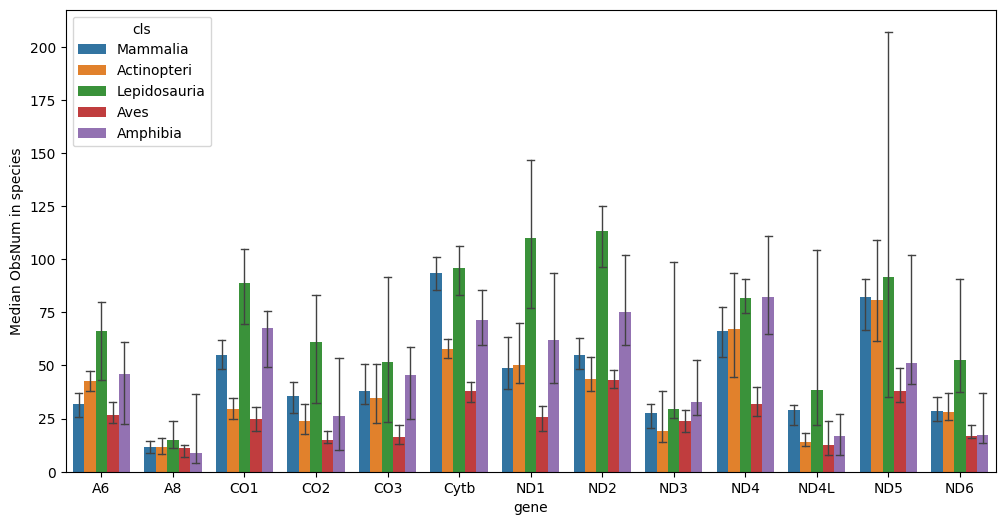

In [31]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=cab.groupby(['cls', 'gene', 'species']).ObsNum.sum().reset_index(), 
    x='gene', y='ObsNum', hue='cls', 
    hue_order=['Mammalia', 'Actinopteri', 'Lepidosauria', 'Aves', 'Amphibia'],
    capsize=0.1, estimator='median', errwidth=1,
).set_ylabel('Median ObsNum in species');

In [8]:
total_data[1][total_data[1].ObsNum >= 0.8]

,Mut,ObsNum,ExpNum,MutSpec,Species,Gene
0,A[A>G]C,1.00000,1.000000,0.036284,Eleotris_fusca,ND1
1,A[A>G]G,0.99709,0.999757,0.036187,Eleotris_fusca,ND1
2,A[T>C]A,1.99157,1.833330,0.039416,Eleotris_fusca,ND1
3,A[T>C]G,1.00000,2.000000,0.018142,Eleotris_fusca,ND1
4,C[A>G]A,0.99995,0.999992,0.036282,Eleotris_fusca,ND1
...,...,...,...,...,...,...
21,T[G>A]G,0.99999,2.399990,0.019425,Branchiostoma_belcheri,ND4L
22,T[G>A]T,1.00000,2.200000,0.021191,Branchiostoma_belcheri,ND4L
23,T[T>C]T,0.99999,12.400000,0.003760,Branchiostoma_belcheri,ND4L
24,T[T>G]G,0.99998,0.999999,0.046620,Branchiostoma_belcheri,ND4L


In [25]:
total_data[0][total_data[0].ObsNum > 1]

,Mut,ObsNum,ExpNum,MutSpec,Species,Gene
0,A>G,11.97280,30.91470,0.370075,Eleotris_fusca,ND1
1,C>T,4.98631,46.08120,0.103398,Eleotris_fusca,ND1
2,G>A,6.98846,21.08200,0.316758,Eleotris_fusca,ND1
3,T>C,8.98184,40.91500,0.209769,Eleotris_fusca,ND1
1,A>G,24.66940,37.15380,0.192592,Lasiurus_blossevillii,ND1
...,...,...,...,...,...,...
1,A>T,2.99996,12.90000,0.083793,Branchiostoma_belcheri,ND4L
3,C>T,3.99998,7.59997,0.189638,Branchiostoma_belcheri,ND4L
4,G>A,5.99982,11.29990,0.191311,Branchiostoma_belcheri,ND4L
7,T>C,2.99998,40.79990,0.026493,Branchiostoma_belcheri,ND4L
